In [1]:
#!python -m spacy download en_core_web_lg

In [3]:
import en_core_web_lg # Large SpaCy model for English language
import numpy as np
import re # regular expressions
import spacy # NLU library
import seaborn as sns
from collections import defaultdict
from sklearn.svm import SVC # Support Vector Classification model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.naive_bayes import GaussianNB


In [3]:
#$python install 

## Version 3: Machine Learning

### Step 3.1: Finding out what he / she wants

In [4]:
# Create training data

data = pd.read_csv("training.csv")

data.head(10)

,sentence,intent
0,does the vaccine work,vaccine
1,should I wash my cloths everyday,transmition
2,how often should i clean my house,transmition
3,can i drink alcohol,food
4,does vaccine have any side effects,vaccine
5,does washing hands helping in reducing transmi...,transmition
6,does covid spread in hot weather,climate
7,should I isolate myself if I observe symptoms,transmition
8,which fruits are helpful in improving immunity,food
9,do vitamin and zinc supplements help,food


In [5]:
data.shape

(55, 2)

D:\Python Envs\tensorflow-general\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


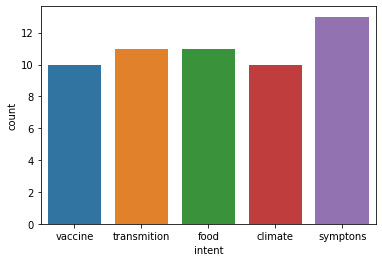

symptons       13
transmition    11
food           11
vaccine        10
climate        10
Name: intent, dtype: int64


In [6]:
sns.countplot(data["intent"])
plt.show()
print(data["intent"].value_counts())

In [7]:
# Change the case of all the sentences to lower case
# remove the non alpha-numeric characters
data['sentence'] = data['sentence'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x.lower())))
data.head

<bound method NDFrame.head of                                              sentence       intent
0                               does the vaccine work      vaccine
1                    should i wash my cloths everyday  transmition
2                   how often should i clean my house  transmition
3                                 can i drink alcohol         food
4                  does vaccine have any side effects      vaccine
5   does washing hands helping in reducing transmi...  transmition
6                    does covid spread in hot weather      climate
7       should i isolate myself if i observe symptoms  transmition
8      which fruits are helpful in improving immunity         food
9                do vitamin and zinc supplements help         food
10                     will vaccine cause weight gain      vaccine
11                  can a pregnant woman take vaccine      vaccine
12         are vaccines safe for people with diabetes      vaccine
13  are vaccines safe for people

In [8]:
# create train-test split
training_sentences,test_sentences,training_intents,test_intents = train_test_split(data['sentence'],data['intent'],test_size = 0.4)

In [9]:
#training_sentences = data['sentence']
#training_intents = data['intent']

In [10]:
# this may take a couple of seconds
nlp = en_core_web_lg.load()
# Calculate the dimensionality of nlp
embedding_dim = nlp.vocab.vectors_length

print(embedding_dim)

300


In [11]:
def encode_sentences(sentences):
    # Calculate number of sentences
    n_sentences = len(sentences)

    print('Length :',n_sentences)

    X = np.zeros((n_sentences, embedding_dim))
    #y = np.zeros((n_sentences, embedding_dim))

    # Iterate over the sentences
    for idx, sentence in enumerate(sentences):
        # Pass each sentence to the nlp object to create a document
        doc = nlp(sentence)
        # Save the document's .vector attribute to the corresponding row in X
        X[idx, :] = doc.vector
    return X

In [27]:
X = encode_sentences(data['sentence'])

Length : 55


In [28]:
# Create a support vector classifier
clf = SVC(C=1, gamma="auto", probability=True)

# Fit the classifier using the training data
clf.fit(X, data['intent'])

SVC(C=1, gamma='auto', probability=True)

In [29]:
from sklearn.svm import LinearSVC
lin_clf = LinearSVC()
lin_clf.fit(X, data['intent'])

LinearSVC()

In [30]:
gnb = GaussianNB()
gnb.fit(X, data['intent'])

GaussianNB()

In [31]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X, data['intent'])

KNeighborsClassifier(n_neighbors=15)

In [32]:
def get_intent_ml(text):
    doc = nlp(text)
    return(lin_clf.predict([doc.vector])[0], gnb.predict([doc.vector])[0],knn.predict([doc.vector])[0])

### Step 3.2 Figure out how to deal with it.

In [33]:
import json

responses_ml = json.load(open("intent_response.json","r"))
responses_ml['default'] = "Help me"

    


def respond_ml(text):
    response = responses_ml.get(get_intent_ml(text), responses_ml["default"])
    return("{}\n{}".format(text, response))

In [36]:
print(get_intent_ml("do i have to isolate?"))
print(get_intent_ml("can i drink cold juice for covid-19?"))
print(get_intent_ml("does the vaccine work"))
print(get_intent_ml("should I wash my cloths everyday"))

('symptons', 'symptons', 'symptons')
('food', 'food', 'symptons')
('vaccine', 'vaccine', 'vaccine')
('transmition', 'transmition', 'symptons')


In [37]:
import pickle

# save
with open('model.pkl','wb') as f:
    pickle.dump(gnb,f)

In [34]:
print(respond_ml("do i have to isolate?"))
print(respond_ml("can i eat any food for covid-19?"))
print(respond_ml("does the vaccine work"))
print(respond_ml("should I wash my cloths everyday"))


do i have to isolate?
Help me
can i eat any food for covid-19?
Help me
does the vaccine work
Help me
should I wash my cloths everyday
Help me


In [20]:
# add this to responses dict: "default": "I love you too!"
# in the predict function: if the model is not too sure about the intent, return the string "default"
    # There is a function that gives the probabilities for each of the possible outputs
    # If the maximum probability is low, one might say that the model is not sure about the intent
    # Note! This idea should work, but relies on the functionality of the predict_proba function:
    # for the SVC model, the predict_proba function does not give meaningfull results for small datasets:
    # http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.predict_proba

def get_intent_ml_2(text):
    """
        Returns the intent from a given text, unless the model is not sure, in which case 'default' is returned
    """
    doc = nlp(text)
    max_proba = max(clf.predict_proba([doc.vector])[0])
    if(max_proba == 0.5):
        return('default')
    else:
        return(clf.predict([doc.vector])[0])

def respond_ml_2(text):
    response = responses_ml.get(get_intent_ml_2(text), responses_ml["default"])
    return("{}\n".format(input=text, output=response))

In [21]:
print(respond_ml('sneeze'))
print(respond_ml_2('sneeze'))

sneeze
Transmission


IndexError: Replacement index 0 out of range for positional args tuple

In [72]:
def get_all_entities(text):
    """
        Get all entities in a given text, in a text: label_ dictionary
    """
    doc = nlp(text)
    
    d = defaultdict(list)
    for ent in doc.ents:
        d[ent.label_].append(ent.text)
    return(d)

In [73]:
test_ents = get_all_entities('what do you know about covid?, or its symptoms or transmission or food clothes isolation')
print(sorted(test_ents.items()))

[]


In [74]:
policy = {
    ("dinner_preference", "time and date"): "I want to eat pasta",
    ("dinner_preference", "time only"): "I want to eat pasta",
    ("dinner_preference", "date only"): "I want to eat pasta",
    ("dinner_preference", "none"): "When?",
    ("arrival_time", "time and date"): "I will be home at six",
    ("arrival_time", "time only"): "I will be home at six",
    ("arrival_time", "date only"): "I will be home at six",
    ("arrival_time", "none"): "When?",
    ("default", "none"): "What do you want?",
}

In [75]:
def respond_ml_3(text):
    intent = get_intent_ml_2(text)
    if intent != 'default':
        entities = get_all_entities(text)
        if 'TIME' in entities and 'DATE' in entities:
            specification = 'time and date'
            time = ' and '.join(entities['DATE']) + ' at ' + ' and '.join(entities['TIME'])
        elif 'TIME' in entities:
            specification = 'time only'
            time = ' and '.join(entities['TIME'])
        elif 'DATE' in entities:
            specification = 'date only'
            time = ' and '.join(entities['DATE'])
        else:
            specification = 'none'
            time = ""
    else:
        specification = 'none'
        time = ""
    
    response = policy.get((intent, specification)) + ' ' + time
    return(output_format.format(input=text, output=response))

In [76]:
preferences {"monday" :"pancakes"}

SyntaxError: invalid syntax (Temp/ipykernel_18704/791215504.py, line 1)

In [70]:
print(respond_ml_3('<a simple question related to covid 19>'))


NameError: name 'respond_ml_3' is not defined